# Tutorial: how to use Pado
This jupyter notebook provides an introduction to Pado. Through this notebook, you will learn the basic building blocks of Pado: light, optical element, and propagator.

In your project folder, put the folder of pado like below
- YOUR PROJECT FOLDER
  - pado
    - complex.py
    - conv.py
    - ...

In [1]:
cd ..

c:\Users\mainuser\Documents\GitHub\pado


In [2]:
pwd

'c:\\Users\\mainuser\\Documents\\GitHub\\pado'

## Step 1: import Pado
First, you should import Pado. Make sure to install all the dependency :) 

In [3]:
import pado
import torch
import matplotlib.pyplot as plt

## Step 2: everything starts from light

The fundamental element of Pado is light. As we want to simulate how light wave interacts with other optical elements and propagate in free space, we should start from defining light. Based on wave optics, we represent light wave as a 2D complex-valued field on a virtual plane. That is, each complex-valued element in the array represents the phase and ampiltude of light wave at that spatial location. 

We should first define the resolution of the light we want to simulate as

In [4]:
R = 1000  # number of rows
C = 1000  # number of columns
pitch = 2e-6  # physical size of each pixel in [m]
wvl = 660e-9  # wavelength of the light in [m]

Then, we define the light. This can be easily done using the class `Light`. By default, it initializes the amplitude as one and the phase as zero, resulting in a planar wave. Note that we  store the data in GPU here, so we supply 'cuda:0' for the device argument. We can visualize the content of light with the `visualize()` function.

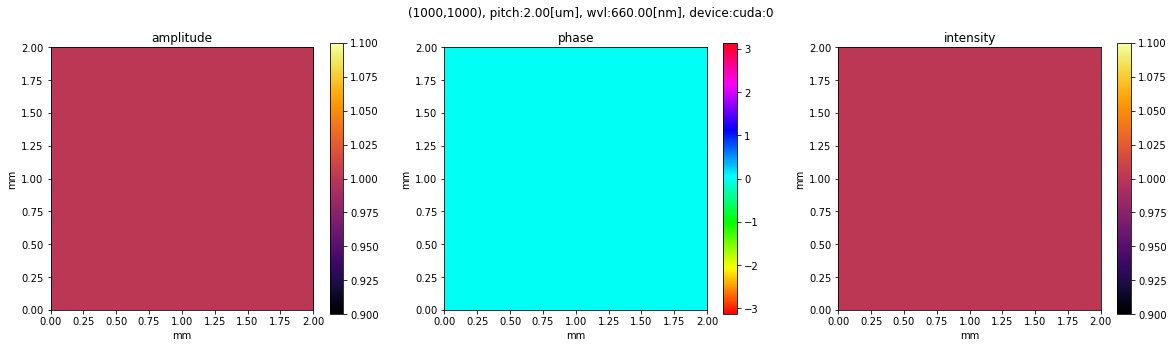

In [5]:
light = pado.light.Light(R,C,pitch,wvl,device='cuda:0')
light.visualize()

## Step 3: build your own imaging/display system
In this tutorial, we will a simple camera with a refractive lens and an aperture. Note that we provide various optical elements that can interact with and transform light wave. Let's first define the basic optical elements: lens and aperture.

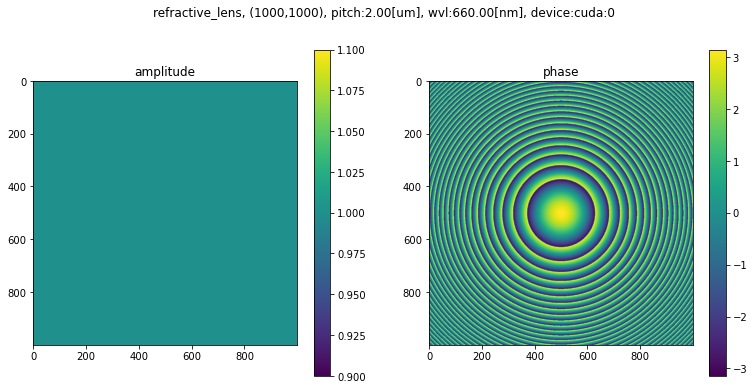

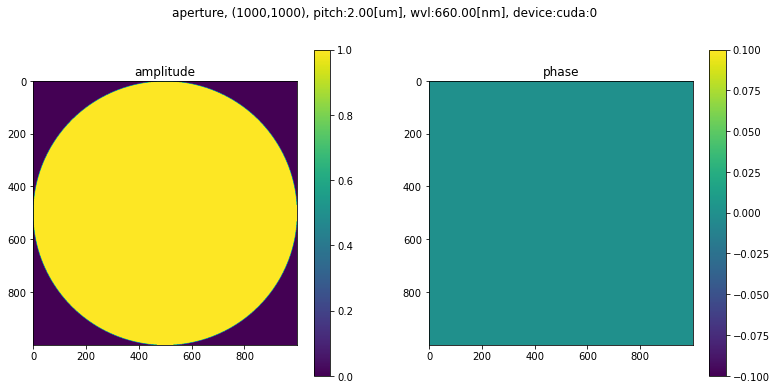

In [6]:
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(R,C,pitch,f,wvl,'cuda:0')
lens.visualize()

aperture = pado.optical_element.Aperture(R,C, pitch, R*pitch, 'circle', wvl, 'cuda:0')
aperture.visualize()


Now, we want to simulate the point spread function (PSF) of this camera. In order to do this, we should use light, lens, aperture, and also propagator. The propagator computes how phase and amplitude of light changes after free-space propagation by a specific distance. Specifically, we use Fresnel propagator which is valid for short propagation distances.

In [7]:
prop = pado.propagator.Propagator('Fresnel')

Let's combine everything together and simulate the system's PSF now. Key here is the function `forward` that takes the light and outputs the light after interaction with either the optical element or the propagator.

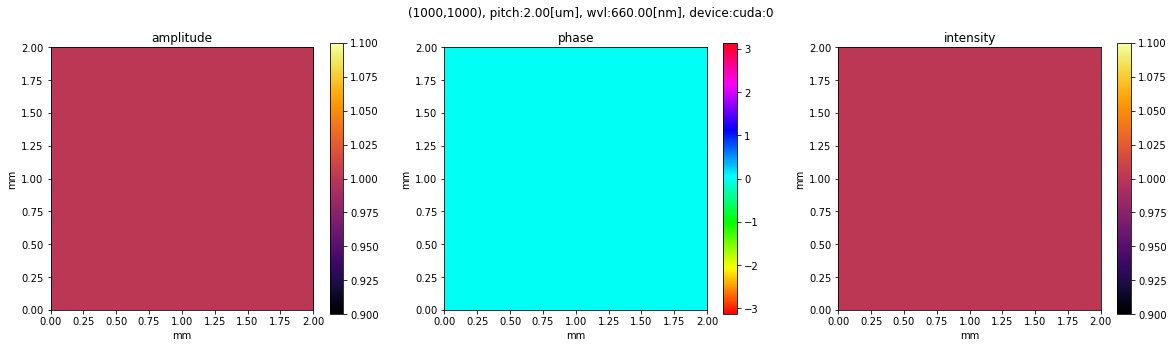

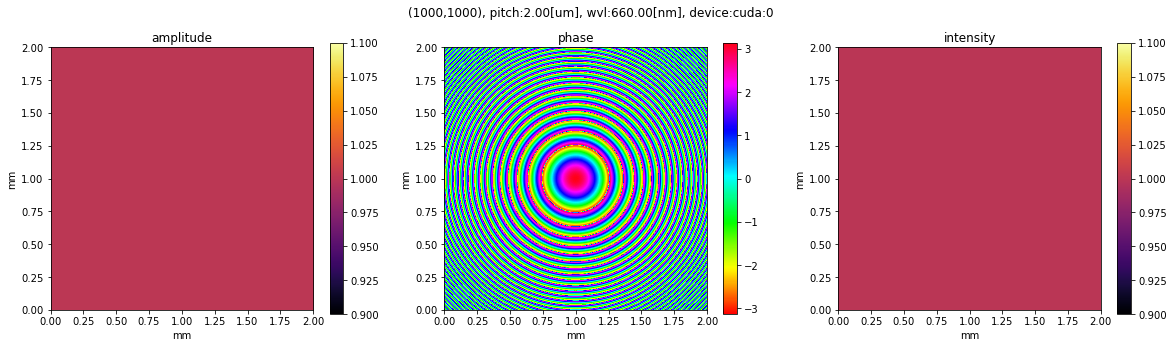

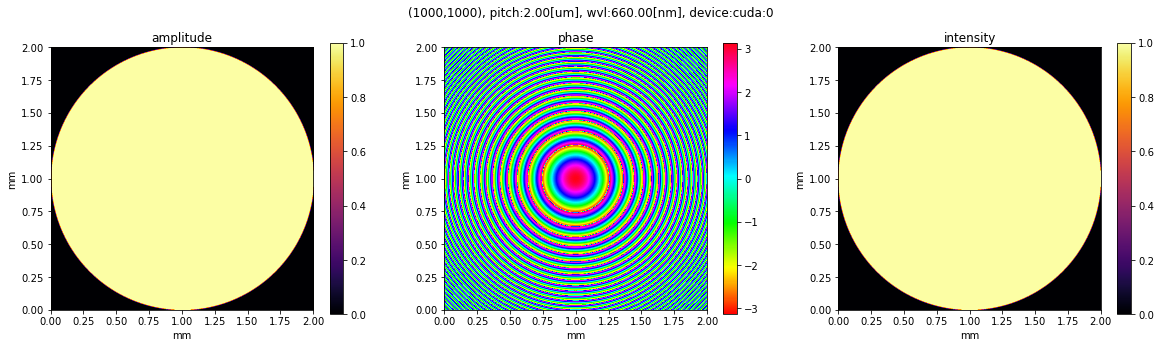

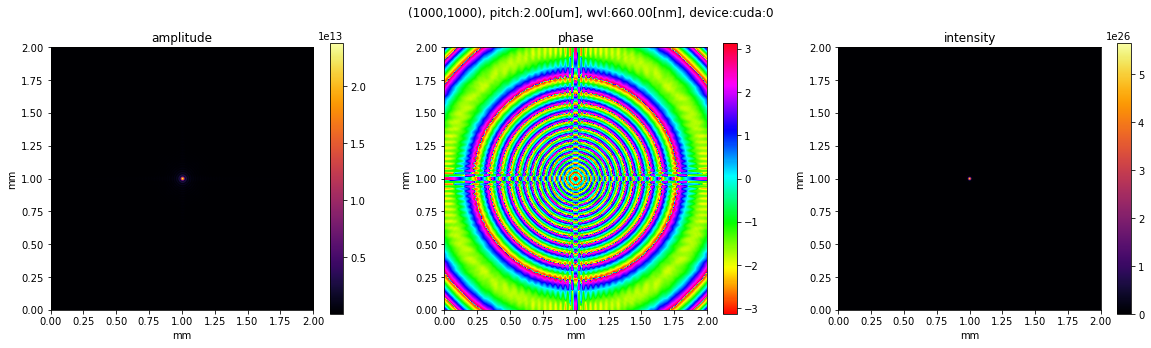

In [8]:
light.visualize()

light_after_lens = lens.forward(light)
light_after_lens.visualize()

light_after_aperture = aperture.forward(light_after_lens)
light_after_aperture.visualize()

light_after_prop = prop.forward(light_after_aperture, f)
light_after_prop.visualize()

The PSF is a diffraction-limited focused dot. 

Text(0.5, 1.0, 'PSF for the coded-aperture camera')

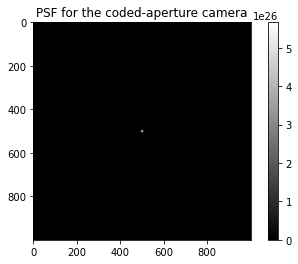

In [9]:
PSF = light_after_prop.get_intensity()

plt.figure()
plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
plt.colorbar()
plt.title('PSF for the coded-aperture camera')

Now, let's make the rendering pipeline as a function so that we can easily call it later. Here, we parameterize the render function with two input parameters of the distance from the lens to the sensor and the aperture's amplitude change profile.

In [10]:
def render(lens2sensor_d, aperture_amp_modulation):
    light = pado.light.Light(R,C,pitch,wvl,device='cuda:0')
    light_after_lens = lens.forward(light)
    aperture.set_amplitude_change(aperture_amp_modulation)
    light_after_aperture = aperture.forward(light_after_lens)
    light_after_prop = prop.forward(light_after_aperture, lens2sensor_d)
    PSF = light_after_prop.get_intensity()
    return PSF

Let's see how the PSF change for the varying distance between the lens and the sensor

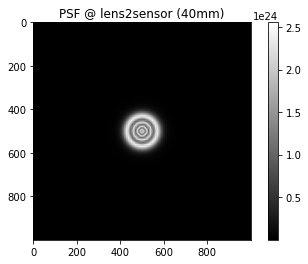

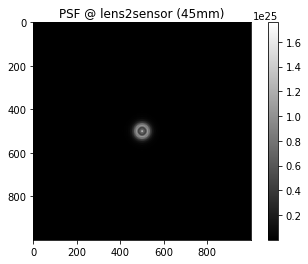

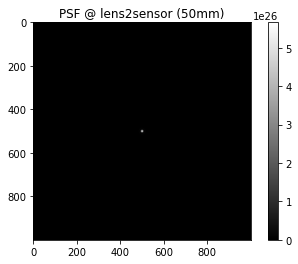

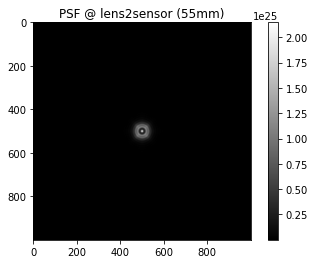

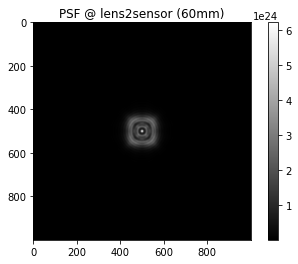

In [11]:
circular_aperture_change = aperture.get_amplitude_change()
for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, circular_aperture_change)

    plt.figure()
    plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
    plt.title('PSF @ lens2sensor (%2.fmm)'%(lens2sensor_d*1e3))
    plt.colorbar()

Now, let's test a coded-aperture configuration, where a new amplitude modulation profile of the aperture is used. 

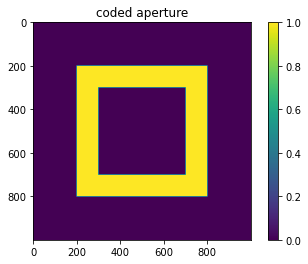

In [12]:
coded_pattern = torch.zeros((1,1,R,C), device='cuda:0')
thickness = 50
coded_pattern[0, 0, R//4-thickness:R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, 3*R//4-thickness:3*R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, C//4-thickness:C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, 3*C//4-thickness:3*C//4+thickness] = 1
plt.figure()
plt.imshow(coded_pattern.data.cpu().numpy().squeeze())
plt.title('coded aperture')
plt.colorbar()

Again, we simulate the PSF for the coded-aperture camera

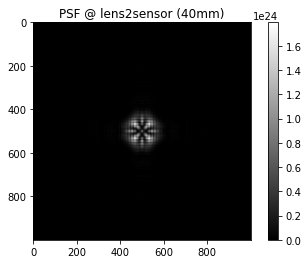

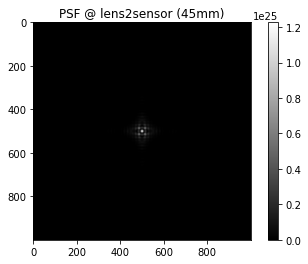

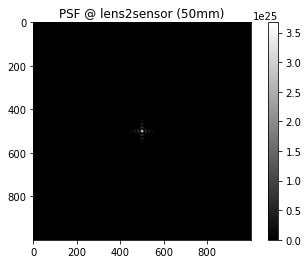

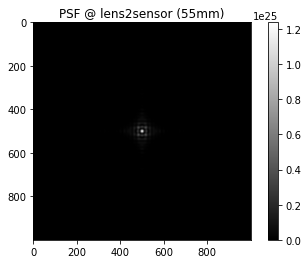

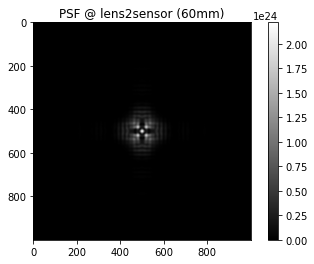

In [13]:
circular_aperture_change = aperture.get_amplitude_change()
for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, coded_pattern)

    plt.figure()
    plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
    plt.title('PSF @ lens2sensor (%2.fmm)'%(lens2sensor_d*1e3))
    plt.colorbar()